In [20]:
import torch

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
report_dir = "/kaggle/working/"
plot_dir = "docs/reports/data"


In [21]:
import logging
from logging.config import dictConfig


logging_config = dict(
    version=1,
    formatters={
        'f': {'format':
              '%(asctime)s %(name)-4s %(levelname)-4s %(message)s'}
    },
    handlers={
        'h': {'class': 'logging.StreamHandler',
              'formatter': 'f',
              'level': logging.DEBUG}
    },
    root={
        'handlers': ['h'],
        'level': logging.DEBUG,
    },
)

dictConfig(logging_config)

logger = logging.getLogger()

# set debug level by default
logger.setLevel(logging.INFO)


In [22]:
class Hyperparameters(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


hp = Hyperparameters(
    epoch=0,
    n_epochs=200,
    dataset_train_mode="train",
    dataset_test_mode="test",
    batch_size=4,
    lr=0.0002,
    decay_start_epoch=100,
    b1=0.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,
    n_critic=5,
    sample_interval=100,
    num_residual_blocks=19,
    lambda_cyc=10.0,
    lambda_id=5.0,
)


In [23]:
from torchvision import transforms

from torch.utils.data import Dataset

import glob

import os

from PIL import Image

import random

class GetDataset(Dataset):
    def __init__(self, input_dir, transforms_=None, unaligned=False, mode="train"):
        super(GetDataset, self).__init__()

        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(input_dir, "%sA" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(input_dir, "%sB" % mode) + "/*.*"))

    def convert_image(self, image):
        rgb_image = Image.new("RGB", image.size)

        return rgb_image.paste(image)

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        if self.is_gray_scale(image_A):
            image_A = self.convert_image(image_A)
        if self.is_gray_scale(image_B):
            image_B = self.convert_image(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)

        return {"A": item_A, "B": item_B}

    def is_gray_scale(self, image):
        return image.mode != "RGB"

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


In [24]:
from PIL import Image

from torchvision import transforms

from torch.utils.data import Dataset

from torchvision.utils import make_grid

from torch.utils.data import DataLoader

class DatasetLoader():
    def __init__(
        self,
        input_path,
    ):
        transforms_ = [
            transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(
                (0.5, 0.5, 0.5),  # this one is the mean
                (0.5, 0.5, 0.5),  # this one is the std
            ),
        ]

        self.train_dataloader = DataLoader(
            GetDataset(input_path, mode=hp.dataset_train_mode, transforms_=transforms_),
            batch_size=hp.batch_size,
            shuffle=True,
            num_workers=1,
        )

        self.val_dataloader = DataLoader(
            GetDataset(input_path, mode=hp.dataset_test_mode, transforms_=transforms_),
            batch_size=16,
            shuffle=True,
            num_workers=1,
        )

        logger.info("Train Images collected: {}".format(len(self.train_dataloader)))
        logger.info("Validation Images collected: {}".format(len(self.val_dataloader)))

    def show_example(self, pic_size=2):
        data_iter = iter(self.train_dataloader)
        images = next(data_iter)

        for i in range(len(images["A"])):
            Plotter().show_img(
                make_grid(images["A"][i], images["B"][i]),
                size=pic_size,
                figname=f"{plot_dir}/example {i}",
            )


In [25]:
class LRLambda:
    def __init__(self, n_epochs, offset, decay_start):
        assert (
            n_epochs - decay_start
        ) > 0, "Decay Needs to start Before Epoch Runs finish"

        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start = decay_start

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start) / (
            self.n_epochs - self.decay_start
        )


In [26]:
import torch

import random

from torch.autograd import Variable


# we utilize the idea of using a set of generated images to test the discriminator
# insted of just passing the latest generated image
# this is a strategy to stabilitze training CycleGAN
class ReplayBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []  # the buffer

    def push_and_pop(self, data):
        to_be_returned = []

        for element in data.data:
            element = torch.unsqueeze(element, 0)  # adds an extra dimension

            if len(self.data) < self.max_size:  # there is some space in the buffer
                self.data.append(element)
                to_be_returned.append(element)
            else:
                # returns a newly added image with a probability of 0.5
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)

                    to_be_returned.append(self.data[i].clone())
                    self.data[i] = element
                else:  # else, return an older image
                    to_be_returned.append(element)

        return Variable(torch.cat(to_be_returned))


In [27]:
from torch import nn


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(
                1
            ),  # paper's recommendation is to start with a Reflection Padding to remove artifacts effect
            # here is a good illustration of what it does:  https://blog.kakaocdn.net/dn/cbZmXN/btrqmJMsdcf/QvrfKkKe7adxj9jJT4hEXK/img.png
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(
                in_channels
            ),  # why not batch, Instance normalizes per-instance, while batch does it per-batch.
            # Why ? check this: https://stackoverflow.com/questions/45463778/instance-normalisation-vs-batch-normalisation
            nn.ReLU(
                inplace=True
            ),  # Destroys the original input, can slightly improve memory but not to be used when the input is needed in further operations
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
        )

    def forward(self, x):
        return x + self.block(x)


In [28]:
import torch.nn as nn

import torch.optim as optim

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape
        self.output_shape = (1, height // 2**4, width // 2**4)

        self.model = nn.Sequential(
            *self._get_discriminator_block(
                channels, out_channels=64, normalize=False
            ),  # C64
            *self._get_discriminator_block(64, out_channels=128),  # 128
            *self._get_discriminator_block(128, out_channels=256),  # C256
            *self._get_discriminator_block(256, out_channels=512),  # C512
            nn.ZeroPad2d(
                (1, 0, 1, 0)
            ),  # this is to keep same Height and Width after applying a kernel of 4*4
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=1),
        )

    def _get_discriminator_block(self, in_channels, out_channels, normalize=True):
        layers = [
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=2,
                padding=1,
            )
        ]

        if normalize:
            layers += [nn.InstanceNorm2d(out_channels)]

        layers += [nn.LeakyReLU(0.2, inplace=True)]

        return layers

    def forward(self, img):
        return self.model(img)

    def create_model(self, input_shape):
        model = Discriminator(input_shape).to(device)

        optimizer = optim.Adam(
            model.parameters(),
            lr=hp.lr,
            betas=(hp.b1, hp.b2),
        )

        return model, optimizer


In [29]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_shape, res_blocks_num):
        super(Generator, self).__init__()

        channels = input_shape[0]
        out_channels = 64

        # c7s1
        model = self._get_input_output_conv(channels, out_channels)

        in_channels = out_channels

        # downsampling: d128, d256
        for _ in range(2):
            out_channels *= 2  # 128 then 256

            model += self._get_ud_conv(in_channels, out_channels)

            in_channels = out_channels

        # resnet blocks
        for _ in range(res_blocks_num):
            model += [ResidualBlock(out_channels)]  # fixed channels (256)

        # upsampling: u128, u64
        for _ in range(2):
            out_channels //= 2  # 128 then 64

            model += self._get_ud_conv(in_channels, out_channels, is_u=True)

            in_channels = out_channels

        # Output Layer:
        model += self._get_input_output_conv(channels, out_channels, is_output=True)

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

    def _get_ud_conv(self, in_channels, out_channels, is_u=False):
        res = []
        stride = 1 if is_u else 2

        if is_u:
            res = [
                nn.Upsample(scale_factor=2),
            ]

        return res + [
            nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=stride, padding=1
            ),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]

    def _get_input_output_conv(self, in_channels, out_channels, is_output=False):
        if is_output:
            return [
                nn.ReflectionPad2d(in_channels),
                nn.Conv2d(out_channels, in_channels, 7),
                nn.Tanh(),
            ]
        else:
            return [
                nn.ReflectionPad2d(in_channels),
                nn.Conv2d(in_channels, out_channels, 7),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]

    def create_model(self, input_shape, resnet_blocks):
        model = Generator(input_shape, resnet_blocks).to(device)

        return model


In [30]:
import torch.nn as nn
import torch.optim as optim

import itertools


class GAN(nn.Module):
    def __init__(self, input_shape):
        super(GAN, self).__init__()

        self.input_shape = input_shape

        self._initialize_generators(input_shape)

        self._initialize_discriminators(input_shape)

        self._initialize_criterions()

        self._initialize_buffers()

        self._initialize_lr_schedulers()

    def _initialize_generators(self, input_shape):
        # initialize generators
        self.gen_AB = Generator(input_shape, hp.num_residual_blocks).create_model(
            input_shape, hp.num_residual_blocks
        )

        self.gen_BA = Generator(input_shape, hp.num_residual_blocks).create_model(
            input_shape, hp.num_residual_blocks
        )

        # initializing the optimizer of generators
        self.optim_G = optim.Adam(
            itertools.chain(self.gen_AB.parameters(), self.gen_BA.parameters()),
            lr=hp.lr,
            betas=(hp.b1, hp.b2),
        )

        self.gen_AB.apply(self._initialize_conv_weights_normal)
        self.gen_BA.apply(self._initialize_conv_weights_normal)

    def _initialize_discriminators(self, input_shape):
        # initialize discriminators
        self.disc_A, self.optim_disc_A = Discriminator(input_shape).create_model(
            input_shape
        )
        self.disc_B, self.optim_disc_B = Discriminator(input_shape).create_model(
            input_shape
        )

        self.disc_A.apply(self._initialize_conv_weights_normal)
        self.disc_B.apply(self._initialize_conv_weights_normal)

    def _initialize_criterions(self):
        self.criterion_GAN = nn.MSELoss()  # GAN loss
        self.identity_criterion = nn.L1Loss()  # identity loss
        self.cycle_criterion = nn.L1Loss()  # cycle consistency

    def _initialize_buffers(self):
        # initialize buffers
        self.fake_A_buffer = ReplayBuffer()
        self.fake_B_buffer = ReplayBuffer()

    def _initialize_lr_schedulers(self):
        # initialize learning rate schedulers (the need to use lr_lambda)
        self.lr_scheduler_G = optim.lr_scheduler.LambdaLR(
            self.optim_G,
            lr_lambda=LRLambda(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step,
        )
        self.lr_scheduler_disc_A = optim.lr_scheduler.LambdaLR(
            self.optim_disc_A,
            lr_lambda=LRLambda(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step,
        )
        self.lr_scheduler_disc_B = optim.lr_scheduler.LambdaLR(
            self.optim_disc_B,
            lr_lambda=LRLambda(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step,
        )

    def _initialize_conv_weights_normal(self, m):
        classname = m.__class__.__name__

        if classname.find("Conv") != -1:  # it is a conv layer
            nn.init.normal_(m.weight.data, 0.0, 0.02)  # paper params

            if hasattr(m, "bias") and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find("BatchNorm2d") != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.weight.bias, 0.0)


In [42]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import time
import datetime

from torch.autograd import Variable

from torchvision.utils import save_image
from torchvision.utils import make_grid

from IPython.display import clear_output

import matplotlib.pyplot as plt

class ModelTrainer:
    training_data_loader = None

    model, criterion = None, None

    loss_from_discriminator_model = []
    loss_from_generator_model = []

    epochs = 5

    def __init__(
        self,
        training_data_loader,
        validation_data_loader,
        model: GAN,
        input_shape,
        epochs,
    ):
        self.training_data_loader = training_data_loader
        self.val_dataloader = validation_data_loader

        self.model = model

        self.epochs = epochs

        self.input_shape = input_shape

    def _calculate_identity_loss(self, real_A, real_B):
        # Recall the concept of identity loss (introduced in the paper)
        # it specifies that the generators need to be aware of domain A and B
        # and if fed an images from domain B (instead of the base A), it needs
        # return the same image, as a proof that it has nothing to do to it
        identity_loss_A = self.model.identity_criterion(
            self.model.gen_BA(real_A), real_A
        )  # notice how we are passing real_A (instead of real_B) even though
        # the generator model is supposed to be fed real_B
        # this loss measures the generator's awareness of the differences between
        # the domains A and B
        identity_loss_B = self.model.identity_criterion(
            self.model.gen_AB(real_B), real_B
        )  # we do the same with gen_AB

        return (identity_loss_A + identity_loss_B) / 2

    def _calculate_GAN_loss(self, real_A, real_B, valid):
        # loss for GAN_AB
        fake_B = self.model.gen_AB(real_A)
        loss_GAN_AB = self.model.criterion_GAN(self.model.disc_B(fake_B), valid)

        # loss for GAN_BA
        fake_A = self.model.gen_BA(real_B)
        loss_GAN_BA = self.model.criterion_GAN(self.model.disc_A(fake_A), valid)

        return (loss_GAN_AB + loss_GAN_BA) / 2, fake_A, fake_B

    def _calculate_cycle_loss(self, real_A, real_B, fake_A, fake_B):
        # now, we compute the cycle consistency loss
        reconstructed_A = self.model.gen_BA(fake_B)

        cycle_loss_A = self.model.cycle_criterion(real_A, reconstructed_A)

        reconstructed_B = self.model.gen_AB(fake_A)
        cycle_loss_B = self.model.cycle_criterion(real_B, reconstructed_B)

        return (cycle_loss_A + cycle_loss_B) / 2

    def _calculate_losses(self, real_A, real_B, valid, lambda_id, lambda_cyc):
        identity_loss = self._calculate_identity_loss(real_A, real_B)
        loss_GAN, fake_A, fake_B = self._calculate_GAN_loss(real_A, real_B, valid)
        cycle_loss = self._calculate_cycle_loss(real_A, real_B, fake_A, fake_B)

        # computing the total loss
        total_loss = loss_GAN + lambda_id * identity_loss + lambda_cyc * cycle_loss
        total_loss.backward()
        self.model.optim_G.step()

        return total_loss, fake_A, fake_B

    def _train_disc_A(self, real_A, fake_A, valid, fake):
        self.model.optim_disc_A.zero_grad()

        real_loss = self.model.criterion_GAN(self.model.disc_A(real_A), valid)

        fake_A_ = self.model.fake_A_buffer.push_and_pop(fake_A)
        fake_loss = self.model.criterion_GAN(self.model.disc_A(fake_A_.detach()), fake)

        loss_disc_A = (real_loss + fake_loss) / 2

        loss_disc_A.backward()
        self.model.optim_disc_A.step()

        return loss_disc_A

    def _train_disc_B(self, real_B, fake_B, valid, fake):
        self.model.optim_disc_B.zero_grad()

        real_loss = self.model.criterion_GAN(self.model.disc_B(real_B), valid)

        fake_B_ = self.model.fake_B_buffer.push_and_pop(fake_B)
        fake_loss = self.model.criterion_GAN(self.model.disc_B(fake_B_.detach()), fake)

        loss_disc_B = (real_loss + fake_loss) / 2

        loss_disc_B.backward()
        self.model.optim_disc_B.step()

        return loss_disc_B

    def _train_discriminators(self, real_A, real_B, fake_A, fake_B, valid, fake):
        # now we train discriminator A
        loss_disc_A = self._train_disc_A(real_A, fake_A, valid, fake)

        # now we train discriminator B
        loss_disc_B = self._train_disc_B(real_B, fake_B, valid, fake)

        return (loss_disc_A + loss_disc_B) / 2

    def train_model(self, lambda_id, lambda_cyc, start_epoch=0, sample_interval=100):
        start = time.time()

        if start_epoch >= self.epochs:
            raise Exception("Starting Epoch exceeds Max Epochs")

        for epoch in range(start_epoch, self.epochs):
            print(f"Currently training on Epoch {epoch+1}")

            for i, batch in enumerate(self.training_data_loader):
                real_A = Variable(batch["A"].type(Tensor))
                real_B = Variable(batch["B"].type(Tensor))

                valid = Variable(
                    Tensor(np.ones((real_A.size(0), *self.model.disc_A.output_shape))),
                    requires_grad=True,
                )
                fake = Variable(
                    Tensor(np.zeros((real_A.size(0), *self.model.disc_A.output_shape))),
                    requires_grad=True,
                )

                # set gans to train mode
                self.model.gen_AB.train()  # gen_AB(real_A) = fake_B
                self.model.gen_BA.train()  # gen_BA(real_B) = fake_A

                # clean passed gradients values
                self.model.optim_G.zero_grad()

                # we start by computing the losses
                total_loss, fake_A, fake_B = self._calculate_losses(
                    real_A, real_B, valid, lambda_id, lambda_cyc
                )

                loss_D = self._train_discriminators(
                    real_A, real_B, fake_A, fake_B, valid, fake
                )

                batches_done = epoch * len(self.training_data_loader) + i
                batches_left = (
                    self.epochs * len(self.training_data_loader) - batches_done
                )

                time_left = datetime.timedelta(
                    seconds=batches_left * (time.time() - start)
                )
                start = time.time()

                if batches_done % 100 == 0:
                    print(
                    "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] ETA: %s"
                    % (
                        epoch,
                        self.epochs,
                        i,
                        len(self.training_data_loader),
                        loss_D.item(),
                        total_loss.item(),
                        time_left,
                    )
                )

                # If at sample interval save image
            if batches_done % sample_interval == 0:
                print("Saving")
                clear_output()
                self.plot_output(self.save_img_samples(batches_done), 30, 40)

    def plot_loss(self):
        step_bins = 20

        num_examples = (len(self.loss_from_generator_model) // step_bins) * step_bins
        plt.plot(
            range(num_examples // step_bins),
            torch.Tensor(self.loss_from_generator_model[:num_examples])
            .view(-1, step_bins)
            .mean(1),
            label="Generator Loss",
        )
        plt.plot(
            range(num_examples // step_bins),
            torch.Tensor(self.loss_from_discriminator_model[:num_examples])
            .view(-1, step_bins)
            .mean(1),
            label="Discriminator Loss",
        )
        plt.legend()
        plt.show()

        plt.savefig(f"{report_dir}/loss_plot.png")

    def plot_output(path, x, y):
        img = mpimg.imread(path)
        plt.figure(figsize=(x, y))
        plt.imshow(img)
        plt.show()


    def save_img_samples(self, batches_done, report_dir):
        """Saves a generated sample from the test set and plots the result"""
        print("batches_done ", batches_done)

        # Get a batch of validation data
        imgs = next(iter(self.val_dataloader))

        # Set models to evaluation mode
        self.model.gen_AB.eval()
        self.model.gen_BA.eval()

        # Get real and fake images
        real_A = Variable(imgs["A"].type(Tensor))
        fake_B = self.model.gen_AB(real_A)
        real_B = Variable(imgs["B"].type(Tensor))
        fake_A = self.model.gen_BA(real_B)

        # Arrange images along the x-axis
        real_A = make_grid(real_A, nrow=16, normalize=True)
        real_B = make_grid(real_B, nrow=16, normalize=True)
        fake_A = make_grid(fake_A, nrow=16, normalize=True)
        fake_B = make_grid(fake_B, nrow=16, normalize=True)

        # Arrange images along the y-axis
        image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)

        # Save image to file
        path = report_dir + "/%s.png" % batches_done
        save_image(image_grid, path, normalize=False)

        # Plot the result
        plt.figure(figsize=(16, 8))
        plt.imshow(image_grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')  # Turn off axis labels
        plt.show()

        return path



In [41]:
if __name__ == "__main__":
    loaded_data = DatasetLoader(
        input_path="/kaggle/input/summer2winter-yosemite",
    )

    # loaded_data.show_example()
    input_shape = (hp.channels, hp.img_size, hp.img_size)

    model = GAN(input_shape)

    trainer = ModelTrainer(
        training_data_loader=loaded_data.train_dataloader,
        validation_data_loader=loaded_data.val_dataloader,
        model=model,
        input_shape=input_shape,
        epochs=30,
    )

    trainer.train_model(lambda_id=hp.lambda_id, lambda_cyc=hp.lambda_cyc)


2024-09-09 19:45:19,624 root INFO Train Images collected: 308
2024-09-09 19:45:19,625 root INFO Validation Images collected: 20


Currently training on Epoch 1
[Epoch 0/30] [Batch 0/308] [D loss: 1.658733] [G loss: 12.988028] ETA: 1:33:24.794970
[Epoch 0/30] [Batch 100/308] [D loss: 0.295692] [G loss: 5.453425] ETA: 1:21:51.031961
[Epoch 0/30] [Batch 200/308] [D loss: 0.238855] [G loss: 3.562761] ETA: 1:21:07.424221
[Epoch 0/30] [Batch 300/308] [D loss: 0.238135] [G loss: 3.986982] ETA: 1:20:14.527402
Currently training on Epoch 2
[Epoch 1/30] [Batch 92/308] [D loss: 0.218743] [G loss: 3.576628] ETA: 1:19:10.346289
[Epoch 1/30] [Batch 192/308] [D loss: 0.279625] [G loss: 3.605466] ETA: 1:18:28.053451
[Epoch 1/30] [Batch 292/308] [D loss: 0.281920] [G loss: 3.549456] ETA: 1:17:27.921295
Currently training on Epoch 3
[Epoch 2/30] [Batch 84/308] [D loss: 0.204197] [G loss: 3.688230] ETA: 1:16:33.405132
[Epoch 2/30] [Batch 184/308] [D loss: 0.202481] [G loss: 3.358135] ETA: 1:15:43.940506
[Epoch 2/30] [Batch 284/308] [D loss: 0.234257] [G loss: 4.309728] ETA: 1:14:37.994914
Currently training on Epoch 4
[Epoch 3/30] 

In [44]:
trainer.save_img_samples(20)

batches_done  20


'/kaggle/working//20.png'

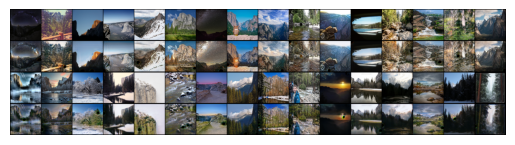

In [47]:
img = mpimg.imread('/kaggle/working//20.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()